# Machine Learning for classifying SARS-CoV-2 data

## Overview 
SARS-Cov-2 MPro is one of the most studied enzymes for the development of an effective treatment against COVID-19. 
It has an active role on the viral replication, for being catalyst of the virus' polyprotein in functional proteins (Anand et al. 2002). Therefore, application of virtual screening (VS) allied to molecular docking appears as an option for the search of a pharmacore candidate which can modulate MPro activity, reducing the viral load (Chen, Yiu, and Wong 2020).     

This notebook is the result of an application of Structure-Based Virtual Screening (SBVS), molecular descriptors and machine learning techniques for identifying active and inactive compounds given a SARS-CoV-2 assay. [Postera.ai](https://covid.postera.ai/covid/activity_data)'s bioassay is the main set, which RapidFire and fluorescence data are used for dividing and labeling the train and test sets' compounds into active and inactive. The constructed models are then assessed as to their ability to classify active and inactive coumpounds given a number of descriptors.

Each model was constructed with a Pipeline of SMOTE and StandardScaler, which were used for rebalancing and scaling the data, respectively. Then, StratifiedKFold was used for training and cross-validating the model. Finally, roc_auc_score, geometric_mean_score and f2_score were used as metrics for choosing the best set of descriptors for each model (XGBClassifier, RandomForestClassifier, etc.). 

The best model was KNeighborsClassifier, which had the highest early recognition according to its ROC curve, followed by LinearDiscriminantAnalysis, LinearSVC and LogisticRegression, which produced similar results. XGBClassifier, DecisionTreeClassifier and RandomForestClassifier had the lowest roc_auc_score, though all models outperformed the models that considered only the docking scores.

## References
Anand K et al. Structure of coronavirus main proteinase reveals combination of a chymotrypsin fold with an extra alpha-helical domain. EMBO J. 2002 Jul 1;21(13):3213-24.    

Chen YW et al. Prediction of the SARS-CoV-2 (2019-nCoV) 3C-like protease (3CL pro) structure: virtual screening reveals velpatasvir, ledipasvir, and other drug repurposing candidates. F1000Res. 2020 Feb 21;9:129.    

## Table of contents

0. [Imports](#imports)    
1. [Reading data](#reading_data)    
    1. [Activity data](#activity_data)    
    2. [Molecular docking and molecular descriptors](#molecular)    
2. [Machine learning](#machine_learning)     
    1. [Constructing the models](#constructing)     
    2. [Scoring metrics](#scoring_metrics)     
    3. [Running the models](#running)    
3. [Results](#results)    
    1. [Performace analysis](#performance_analysis)       
    2. [Finding the best subset](#finding)      
    3. [Reconstructing the top models](#reconstructing)    
    4. [ROC curves](#roc_curves)    
    5. [Regression plots](#regression)    
4. [Supplementary data](#supplementary)    
    1. [Correlations](#correlations)    
    2. [Comparing models and labels](#comparing)   
    3. [Docking scores and performance increment](#docking)    
    4. [Top descriptors](#top_descriptors)    
    5. [Confusion matrix for the best model](#confusion_matrix)     

<a id='imports'></a>
## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.metrics import geometric_mean_score

import multiprocessing
from functools import partial
import itertools
import time
import os
import subprocess

<a id='reading_data'></a>
## Reading data
<a id='activity_data'></a>
### Activity data

,r_inhibition_at_50_uM,f_inhibition_at_50_uM
r_inhibition_at_50_uM,1.00000,0.69973
f_inhibition_at_50_uM,0.69973,1.00000


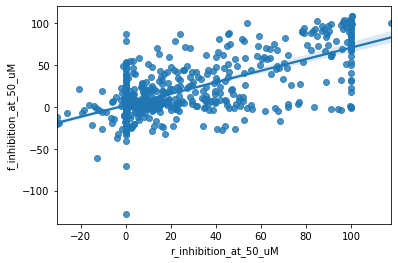

In [2]:
def write_data():
    import requests
    
    url = 'https://covid.postera.ai/covid/activity_data.csv'
    r = requests.get(url, allow_redirects=True)

    with open('activity_data.csv', 'wb') as f:
        f.write(r.content)
        
## Fetch activity data
#write_data()

# Read activity data
activity = pd.read_csv('activity_data.csv')

# Correlation between "RapidFire" assay and fluorescence assay
sns.regplot(x=activity['r_inhibition_at_50_uM'], y=activity['f_inhibition_at_50_uM'])
activity[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']].corr()

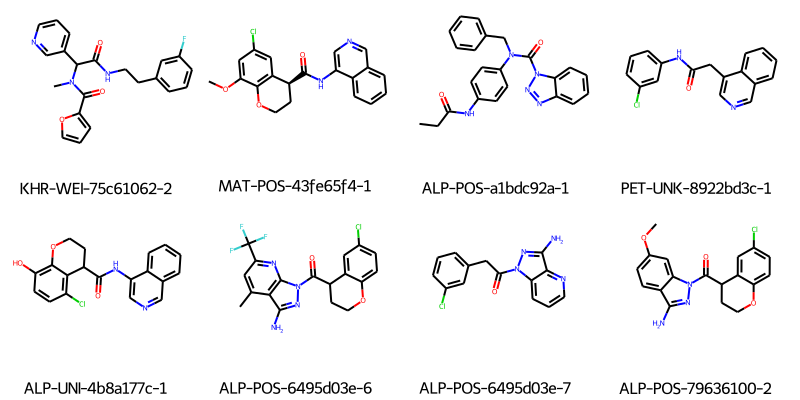

In [3]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

# Write into smiles
activity[['SMILES','CID']].to_csv('smiles.smi', sep=' ', index=False, header=None)
suppl = Chem.SmilesMolSupplier('smiles.smi')


# ExactMolWt / HeavyAtomMolWt (peso sem hidrogênios) / MolWt (média)
# HeavyAtomCount

# Compute 2D coordinates
ms = [x for x in suppl if x is not None]
d_list = []
for m in ms:
    d_list.append({'CID': m.GetProp('_Name'), 
                   'MolMR': Descriptors.MolMR(m), 
                   'NumRotatableBonds': Descriptors.NumRotatableBonds(m), 
                   'NumHAcceptors': Descriptors.NumHAcceptors(m), 
                   'NumHDonors': Descriptors.NumHDonors(m), 
                   'TPSA': Descriptors.LabuteASA(m), 
                   'LabuteASA': Descriptors.LabuteASA(m), 
                   'MolLogP': Descriptors.MolLogP(m)})
descriptors = pd.DataFrame(d_list)

# Draw
from rdkit.Chem import Draw
Draw.MolsToGridImage(ms[:8],
                     molsPerRow=4,
                     subImgSize=(200,200),
                     legends=[x.GetProp("_Name") for x in ms[:8]])    

<a id='molecular'></a>
### Molecular docking and molecular descriptors

In [4]:
# Read QuickVina02 results
qvina         = pd.read_csv('qvina.csv')
qvina.columns = ['CID','pose','qvina']

# Read QVina rescored with RF-Score
rfscore_qvina         = pd.read_csv('rfscore_qvina.csv')
rfscore_qvina.columns = ['CID','pose','rfscore_qvina']

# Top QVina poses
top_qvina  = pd.merge(qvina.query('pose == 1'), rfscore_qvina.query('pose == 1'))
top_qvina.drop('pose', axis=1, inplace=True)

# Read PLANTS results
plants         = pd.read_csv('plants.csv')
plants.columns = ['CID','pose','plants']

# Read PLANTS rescored with RF-Score
rfscore_plants         = pd.read_csv('rfscore_plants.csv', header=None)
rfscore_plants.columns = ['rfscore_plants','CID']
rfscore_plants         = rfscore_plants[['CID','rfscore_plants']]
rfscore_plants[['CID','pose']] = rfscore_plants['CID'].str.split('_', expand=True)
rfscore_plants['pose']         = rfscore_plants['pose'].astype('int')

# Top PLANTS poses
top_plants = pd.merge(plants.query('pose == 1'), rfscore_plants.query('pose == 1'))
top_plants.drop('pose', axis=1, inplace=True)

# Merge top scores and experimental data
tmp = pd.merge(top_qvina, top_plants)
top = pd.merge(tmp, activity[['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']])
del tmp

# Merge descriptors to "top"
data = pd.merge(descriptors, top)

# Label actives and inactives in relation to "RapidFire"
data['r_active'] = data['r_inhibition_at_50_uM'] > 50
data['r_active'] = data['r_active'].astype(int) # 1 for active, 0 for inactive

# Label actives and inactives in relation to the fluorescence assay
data['f_active'] = data['f_inhibition_at_50_uM'] > 50
data['f_active'] = data['f_active'].astype(int) # 1 for active, 0 for inactive

data

,CID,MolMR,NumRotatableBonds,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,r_inhibition_at_50_uM,f_inhibition_at_50_uM,r_active,f_active
0,MAT-POS-02ae579f-1,142.9562,8,3,1,216.479769,216.479769,6.46320,-7.7,7.746907,-93.0745,7.544520,NaN,0.007703,0,0
1,MAT-POS-02ae579f-2,73.8221,2,3,3,115.581247,115.581247,1.51050,-7.2,6.285345,-80.1747,6.407342,NaN,2.287651,0,0
2,LOR-NOR-f9b26152-1,45.9122,1,3,1,78.672385,78.672385,0.96910,-5.5,4.929599,-59.7841,5.100658,7.794489,3.016446,0,0
3,LON-WEI-2e27a2e5-2,146.2802,8,4,1,222.124736,222.124736,5.66020,-7.3,7.575922,-97.6586,7.776974,NaN,-6.337255,0,0
4,MAT-POS-af71705c-1,86.0674,2,4,2,125.972082,125.972082,2.57750,-6.2,6.609277,-54.8444,6.834465,0.000000,-0.727192,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,DAR-DIA-23aa0b97-15,66.1254,2,3,2,102.857248,102.857248,2.77400,-6.2,5.479310,-62.0836,5.861192,-0.075000,16.821870,0,0
939,DAR-DIA-23aa0b97-17,65.5227,3,4,1,104.126584,104.126584,1.52948,-6.5,6.595699,-74.1667,7.054006,12.695000,21.805805,0,0
940,DAR-DIA-23aa0b97-19,85.2337,3,3,1,127.588600,127.588600,3.28768,-6.6,6.733870,-79.4982,6.852397,85.160000,73.019885,1,1
941,DAR-DIA-23aa0b97-20,80.5187,3,2,1,116.831078,116.831078,3.41600,-7.0,6.307346,-77.3610,6.383954,62.475000,57.793870,1,1


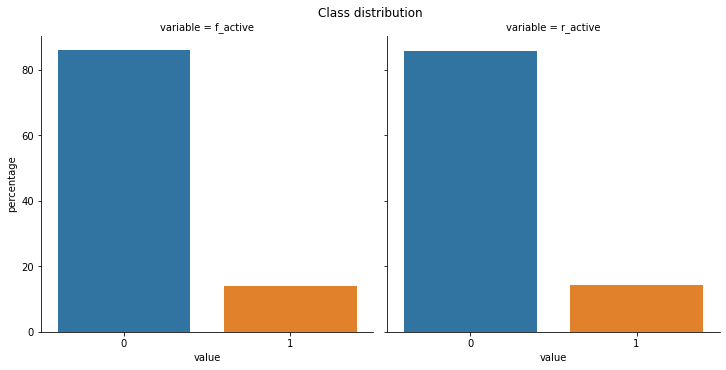

In [5]:
# Descriptors
descriptor_list = list(descriptors.columns[1:])
docking_list = ['qvina','rfscore_qvina','plants','rfscore_plants']

trainset = descriptor_list + docking_list
data.dropna(subset=trainset, inplace=True)

tmp = pd.melt(data, id_vars=['CID'], value_vars=['r_active','f_active'])
tmp2 = (tmp.groupby(['variable'])['value'].value_counts(
    normalize=True).rename('percentage').mul(100).reset_index().sort_values('value'))
g = sns.catplot(data=tmp2, kind='bar', x='value', y='percentage', col='variable')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Class distribution')

del tmp, tmp2

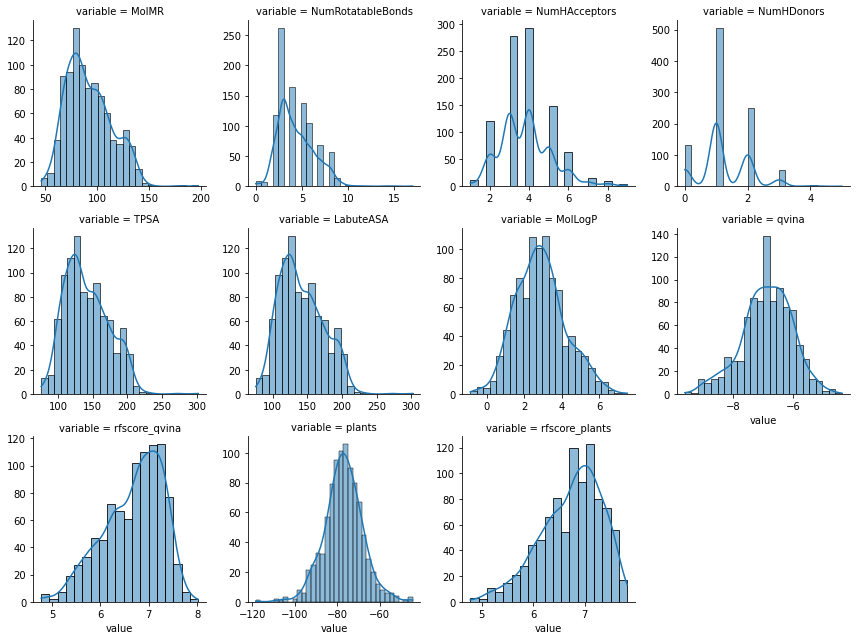

In [6]:
tmp = pd.melt(data, id_vars=['CID'], value_vars=trainset)
g = sns.FacetGrid(data=tmp, col='variable', col_wrap=4, sharex=False, sharey=False)
del tmp
g.map(sns.histplot, 'value', kde=True)

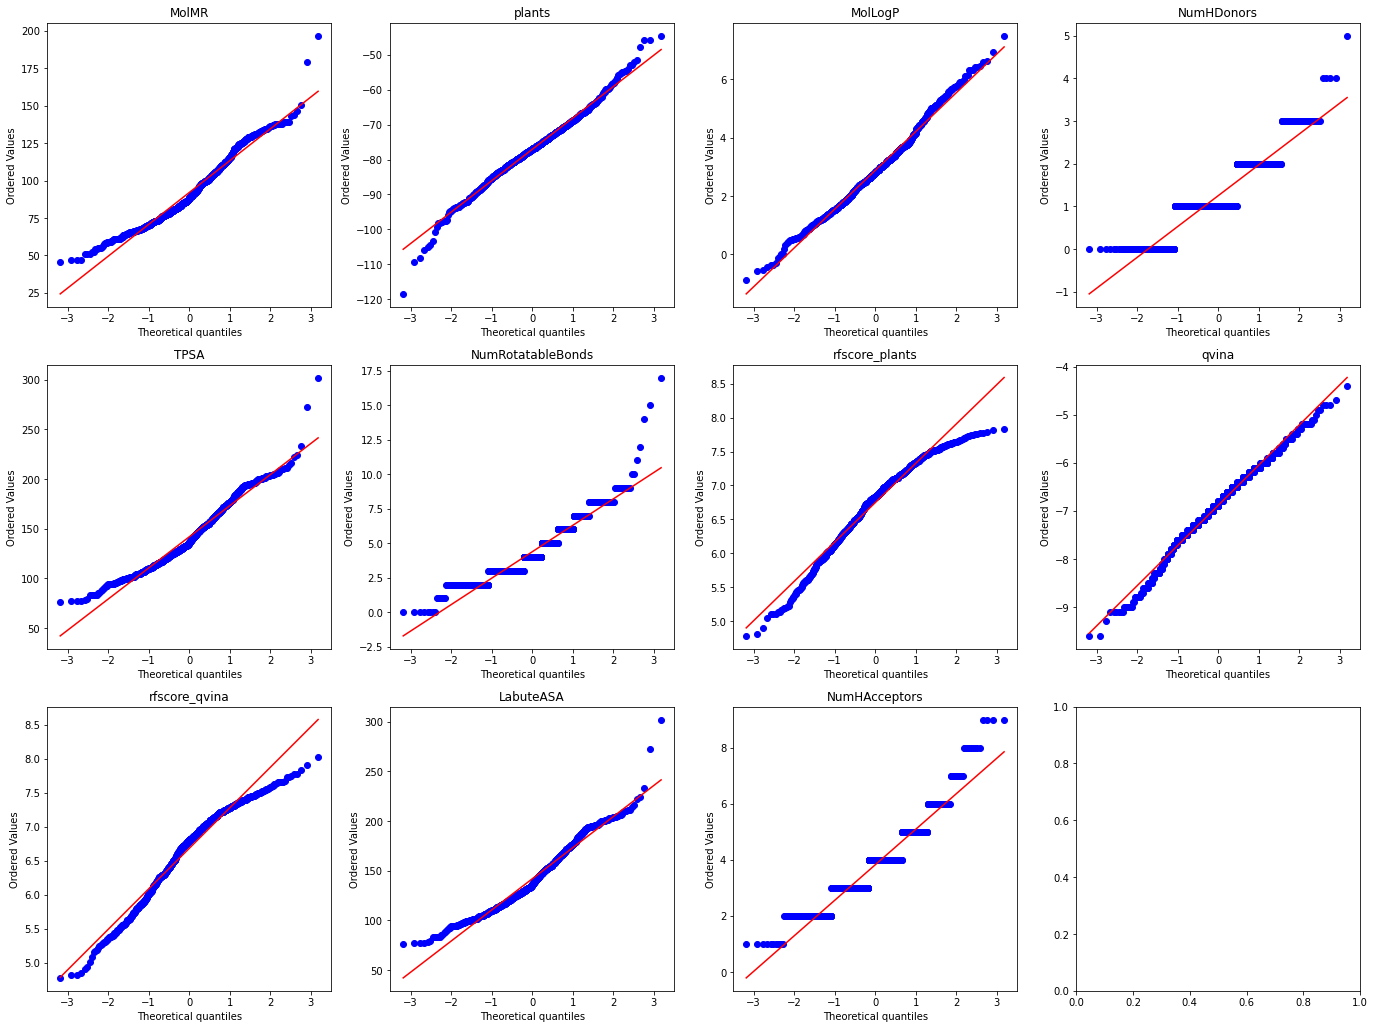

In [7]:
def qq_plot(X):
    from scipy.stats import probplot

    ncol = 4
    nrow = int(np.ceil(len(X.columns) / ncol))
    
    fig, ax = plt.subplots(nrow, ncol, figsize=(ncol * 4.8, nrow * 4.8))
    for i, x in enumerate(X.columns):
        probplot(data[x], dist='norm', plot=ax[i%nrow, i%ncol])
        ax[i%nrow, i%ncol].set_title(x)

    fig.tight_layout()
    plt.show()

qq_plot(data[trainset])

The data is approximately normaly distributed, and can be standardized. However, some descriptors present skewness and the QQ-Plot shows the outermost data has greater variance, which could indicate heteroskedacity (non-constant variance). 

<a id='machine_learning'></a>
## Machine learning
<a id='constructing'></a>
### Constructing the models

In [8]:
def get_combinations(min_len, list1, *args):
    # Get all subsets of a "main" list and N other lists
    combinations = []
    for sublist in args:
        list2 = list1 + sublist
        combinations += list(itertools.chain.from_iterable(
            itertools.combinations(list2, r) for r in range(min_len, len(list2)+1)))

    # Remove duplicates and return list
    return list(dict.fromkeys(combinations))

In [9]:
class MyClass:
    @staticmethod
    def get_model_by_name(model_name):
        if model_name == 'LogisticRegression':
            return LogisticRegression(solver='liblinear', random_state=13)
        elif model_name == 'LinearSVC':
            return CalibratedClassifierCV(LinearSVC(dual=False, random_state=13))
        elif model_name == 'RandomForestClassifier':
            return RandomForestClassifier(n_estimators=10, random_state=13)
        elif model_name == 'KNeighborsClassifier':
            return KNeighborsClassifier(n_neighbors=5)
        elif model_name == 'XGBClassifier':
            return XGBClassifier(objective='reg:logistic', random_state=13)
        elif model_name == 'DecisionTreeClassifier':
            return DecisionTreeClassifier(random_state=13)
        elif model_name == 'LinearDiscriminantAnalysis':
            return LinearDiscriminantAnalysis(solver='svd')
        return None
    
    
    
    
    @staticmethod
    def get_scores(X, y, subset, trainset, scaler, activity_label, model):
        # Rebalance data with SMOTE and cross validate model
        pipe = make_pipeline(SMOTE(random_state=42), scaler, model)

        scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
        metrics = {key: [] for key in scoring_metrics}

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
        for train_index, test_index in skf.split(X, y): 
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
            model_fitted = pipe.fit(X_train, y_train)
            y_pred = model_fitted.predict(X_test)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred)) # test_accuracy
            metrics['precision'].append(precision_score(y_test, y_pred)) # test_precision
            metrics['recall'].append(recall_score(y_test, y_pred)) # test_recall
            metrics['f1'].append(f1_score(y_test, y_pred)) # test_f1
            metrics['f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
            metrics['geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
            metrics['roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc

        # Mean of the KFold scores
        scores = [np.mean(value) for value in metrics.values()]
        scores.append(activity_label)
        scores.append(str(model).split('(')[0])
        scores.append(random_state)

        # Add binary list of the descriptors
        scores.extend([i in subset for i in trainset])
        return scores
    
    
    
    
    @staticmethod
    def run_models(data, scaler, trainset, combinations, columns):
        ncpu = multiprocessing.cpu_count()
        # DataFrame for all models' scores
        scores_data = pd.DataFrame()
        model_list = [LogisticRegression(solver='liblinear', random_state=13), 
                         RandomForestClassifier(n_estimators=10, random_state=13), 
                         KNeighborsClassifier(n_neighbors=5), 
                         LinearSVC(dual=False, random_state=13), 
                         XGBClassifier(objective='reg:logistic', random_state=13), 
                         DecisionTreeClassifier(random_state=13), 
                         LinearDiscriminantAnalysis(solver='svd')]
        for activity_label in ['r_active','f_active']:
            # Drop NaN activity and descriptor values
            new_data = data.dropna(subset=[activity_label])

            # Loop through all subset combinations (2, N)
            for subset in combinations:
                subset = list(subset)

                y = new_data[activity_label]
                X = new_data[subset]

                # List of tuples for Pool().map()
                args = []
                for model in model_list:
                    args.append((activity_label, model))

                with multiprocessing.Pool(processes=ncpu) as pool:
                    scores = pool.starmap(partial(MyClass.get_scores, X, y, subset, trainset, 
                                                    scaler), args)

                # Append scores to all scores
                scores = pd.DataFrame(scores, columns=columns)
                scores_data = scores_data.append(scores)
        return scores_data

<a id='scoring_metrics'></a>
### Scoring metrics

* Accuracy score: true positives / total
* Precision: low false positive rate
* Recall (sensitivity): true positives / all positives
* F1 score: weighted avg of precision and recall ~ better than accuracy for uneven class distribution
* Roc_auc: TPR / FPR

In [10]:
# Get combinations of the molecule descriptors /
#                         molecule descriptors + "qvina" and/or "rfscore_qvina" /
#                         molecule descriptors + "plants" and/or "rfscore_plants"
combinations = get_combinations(2, descriptor_list, 
                                ['qvina','rfscore_qvina'], 
                                ['plants','rfscore_plants'])
# Test metrics
scoring_metrics = ['accuracy','precision','recall','f1','f2','geometric_mean','roc_auc']
test_metrics = ['test_'+ i for i in scoring_metrics]
columns = [*test_metrics, 'activity_label', 'model', 'random_state'] + trainset

scaler = StandardScaler()

<a id='running'></a>
### Running the models

In [11]:
run = False
t0 = time.time()

if run:
    # Run all!
    scores_data = MyClass.run_models(data, scaler, trainset, combinations, columns)
    scores_data[trainset] = scores_data[trainset].astype(int)
    scores_data.to_csv('scores_data.csv', index=False)
    
t1 = time.time()
print('{:g}m:{:g}s'.format(*divmod(t1 - t0, 60)))

0m:0.000216722s


<a id='results'></a>
## Results
<a id='performance_analysis'></a>
### Performance analysis

In [12]:
# Read test scores and sort values
local = False
if local:
    # Local computer
    scores_data = pd.read_csv('scores_data.csv')
else:
    # Cluster results
    scores_data = pd.read_csv('scores_data_cluster.csv.gz', compression='gzip')
    # Groupby "job_id" and get mean of random states (https://stackoverflow.com/a/65028508/13131079)
    d = {True: 'mean', False: 'first'}
    agg_map = {col: d[pd.api.types.is_numeric_dtype(i)] for col, i in zip(
        scores_data.columns, scores_data.dtypes)}
    scores_data = scores_data.groupby('job_id').agg(agg_map).drop(
        ['job_id','random_state'], axis=1).reset_index(drop=True)
    
columns = scores_data.columns
selected = ['test_f2', 'test_geometric_mean', 'test_roc_auc']

# Scale results
scores_data[test_metrics] = StandardScaler().fit_transform(scores_data[test_metrics])
scores_data['test_mean'] = scores_data[selected].mean(axis=1)
scores_data.sort_values('test_mean', ascending=False, inplace=True)
scores_data.groupby('model').head(1)

,test_accuracy,test_precision,test_recall,test_f1,test_f2,test_geometric_mean,test_roc_auc,activity_label,model,MolMR,...,NumHAcceptors,NumHDonors,TPSA,LabuteASA,MolLogP,qvina,rfscore_qvina,plants,rfscore_plants,test_mean
9249,0.529384,1.237482,1.524874,2.066769,2.022205,2.092883,2.164920,f_active,KNeighborsClassifier,False,...,True,True,False,False,True,True,True,False,False,2.093336
6174,0.753650,1.670451,1.300852,2.346526,1.995244,2.023187,2.162664,r_active,LogisticRegression,False,...,True,True,True,True,True,False,False,True,True,2.060365
5004,0.283882,1.119381,1.645056,2.011624,2.075518,2.020987,2.051742,r_active,LinearDiscriminantAnalysis,False,...,True,True,False,True,False,False,False,True,False,2.049416
5603,0.496130,1.366288,1.470480,2.144621,2.015902,1.999711,2.081442,r_active,LinearSVC,True,...,True,True,False,False,True,False,False,True,True,2.032352
68,-0.984071,-0.052385,1.939882,0.872973,1.638897,1.265242,1.077038,r_active,DecisionTreeClassifier,False,...,False,True,False,False,False,False,False,False,False,1.327059
67,-1.010581,-0.066578,1.960090,0.863932,1.644720,1.260258,1.071585,r_active,XGBClassifier,False,...,False,True,False,False,False,False,False,False,False,1.325521
64,-1.011299,-0.073726,1.943170,0.851017,1.628893,1.247992,1.052858,r_active,RandomForestClassifier,False,...,False,True,False,False,False,False,False,False,False,1.309914


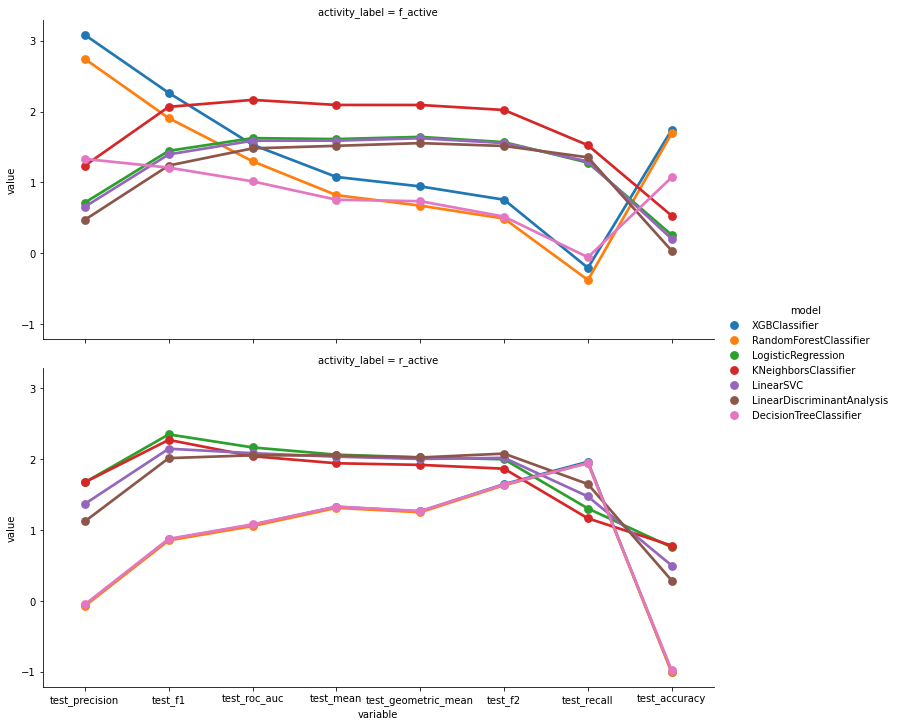

In [13]:
top = pd.melt(scores_data.groupby(['activity_label', 'model']).head(1), id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=top.sort_values('value', ascending=False), x='variable', y='value', hue='model', row='activity_label', aspect=2)
plt.savefig('test_performance.png', dpi=216)

<a id='finding'></a>
### Finding the best subset

In [14]:
# Dictionary: key == model_name, value == list of best descriptors
best_subset = {}

activity_label = scores_data.iloc[0]['activity_label']
for i, row in scores_data.query('activity_label == @activity_label').groupby('model').head(1).iterrows():
    best_subset[row['model']] = [descriptor for descriptor in trainset if row[descriptor]]

<a id='reconstructing'></a>
### Reconstructing the top models

In [15]:
# Probabilities for the top models
train_data = pd.DataFrame()
test_data = pd.DataFrame()

# List of scores for the top models
scores_list = []
new_data = data.dropna(subset=trainset)

test_metrics = selected
train_metrics = [i.replace('test', 'train') for i in selected]
scoring_metrics = test_metrics + train_metrics

count = 0
for key, value in best_subset.items():
    model_name = key
    subset = value
    
    y = new_data[activity_label]
    X = new_data[subset]
            
    scaler = StandardScaler()
    pipe = make_pipeline(SMOTE(random_state=42), scaler, MyClass.get_model_by_name(model_name))
        
    metrics = {key: [] for key in scoring_metrics}
    
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
    for train_index, test_index in skf.split(X, y): 
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
        model_fitted = pipe.fit(X_train, y_train)
        
        y_pred = model_fitted.predict(X_test)
        metrics['test_f2'].append(fbeta_score(y_test, y_pred, beta=2)) # test_f2
        metrics['test_geometric_mean'].append(geometric_mean_score(y_test, y_pred)) # test_geometric_mean
        metrics['test_roc_auc'].append(roc_auc_score(y_test, y_pred)) # test_roc_auc
        
        y_pred = model_fitted.predict(X_train)
        metrics['train_f2'].append(fbeta_score(y_train, y_pred, beta=2)) # train_f2
        metrics['train_geometric_mean'].append(geometric_mean_score(y_train, y_pred)) # train_geometric_mean
        metrics['train_roc_auc'].append(roc_auc_score(y_train, y_pred)) # train_roc_auc
    
    # Mean of the KFold scores
    scores = [np.mean(value) for value in metrics.values()]

    #model_fitted = model.fit(X_train, y_train)
    #scores = get_train_test_scores(X_train, X_test, y_train, y_test, model_fitted)
    scores_list.append([model_name, *scores])
    
    y_proba_train = model_fitted.predict_proba(X_train)
    train_data[model_name] = y_proba_train[:,1]

    y_proba_test = model_fitted.predict_proba(X_test)
    test_data[model_name] = y_proba_test[:,1]
    
    # Keep original indices
    test_data.index = X_test.index
    count+=1

columns = ['model', *scoring_metrics]
top_scores = pd.DataFrame(scores_list, columns=columns)
top_scores['test_mean'] = top_scores[test_metrics].mean(axis=1)
top_scores['train_mean'] = top_scores[train_metrics].mean(axis=1)

<a id='roc_curves'></a>
### ROC curves

,model,test_f2,test_geometric_mean,test_roc_auc,train_f2,train_geometric_mean,train_roc_auc,test_mean,train_mean
0,KNeighborsClassifier,0.488625,0.668802,0.675488,0.750884,0.860917,0.861536,0.610971,0.824445
1,LogisticRegression,0.460125,0.648230,0.655024,0.481066,0.663653,0.668392,0.587793,0.604370
2,LinearSVC,0.461524,0.650235,0.658530,0.479848,0.663562,0.668870,0.590096,0.604093
3,LinearDiscriminantAnalysis,0.468086,0.651881,0.654703,0.478048,0.658888,0.661797,0.591557,0.599578
4,XGBClassifier,0.349291,0.560273,0.611794,0.993100,0.995849,0.995861,0.507119,0.994937
5,RandomForestClassifier,0.335550,0.548042,0.608952,0.926459,0.956293,0.956892,0.497515,0.946548
6,DecisionTreeClassifier,0.406098,0.607576,0.638159,1.000000,1.000000,1.000000,0.550611,1.000000


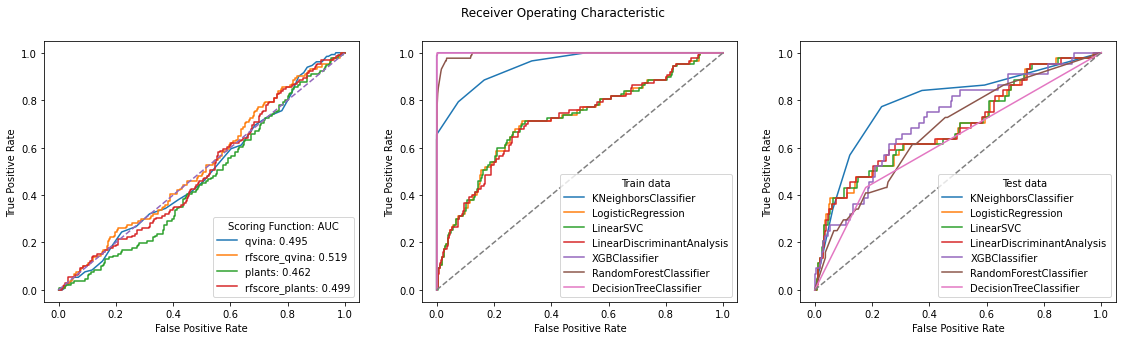

In [16]:
fig, ax = plt.subplots(ncols=3, figsize=(19.2, 4.8))

# Plot ROC curves for the docking scoring functions
for SF in docking_list:
    fpr, tpr, _ = roc_curve(data[activity_label].values, data[SF].values)
    ax[0].plot(fpr, tpr, label=f'{SF}: {auc(fpr, tpr):>.3f}')

# Plot ROC curves for the ML models
for model_name in best_subset.keys():
    fpr_train, tpr_train,_ = roc_curve(y_train, train_data[model_name])
    ax[1].plot(fpr_train, tpr_train, label=f'{model_name}')
    
    fpr_test, tpr_test,_ = roc_curve(y_test, test_data[model_name])
    ax[2].plot(fpr_test, tpr_test, label=f'{model_name}')

for i in range(3):
    # Plot a line
    ax[i].plot([0,1], [0,1], linestyle='--')
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')

# Some legends
ax[0].legend(title='Scoring Function: AUC', loc='lower right')
ax[1].legend(title='Train data')
ax[2].legend(title='Test data')

plt.suptitle('Receiver Operating Characteristic')
plt.savefig('test_roc_curve.png', dpi=216)

top_scores

<a id='regression'></a>
### Regression plots

In [17]:
test_data['CID'] = data.loc[test_data.index]['CID']
tmp = pd.melt(test_data, id_vars=['CID'], value_vars=test_data.columns[:-1])
tmp = tmp.append(pd.melt(data.loc[test_data.index], id_vars=['CID'], value_vars=['qvina','rfscore_qvina','plants','rfscore_plants']))
df_tidy = pd.merge(data.loc[test_data.index][['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM']], tmp, on=['CID'])

del tmp

Spearman R: 0.24860611649737133


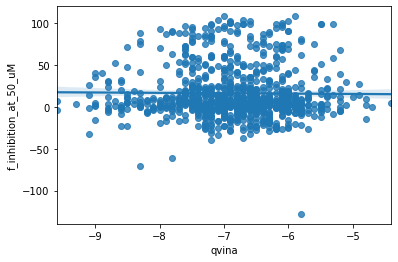

In [18]:
from scipy.stats import spearmanr

tmp = data.dropna(subset=['qvina', 'f_inhibition_at_50_uM'])
print(f"Spearman R: {spearmanr(tmp['qvina'], tmp['f_inhibition_at_50_uM'])[1]}")
del tmp

sns.regplot(data=data, x='qvina', y='f_inhibition_at_50_uM', )
plt.savefig('regplot_qvina.png', dpi=216)

Text(0.5, 0.98, 'Regression plots for the test set')

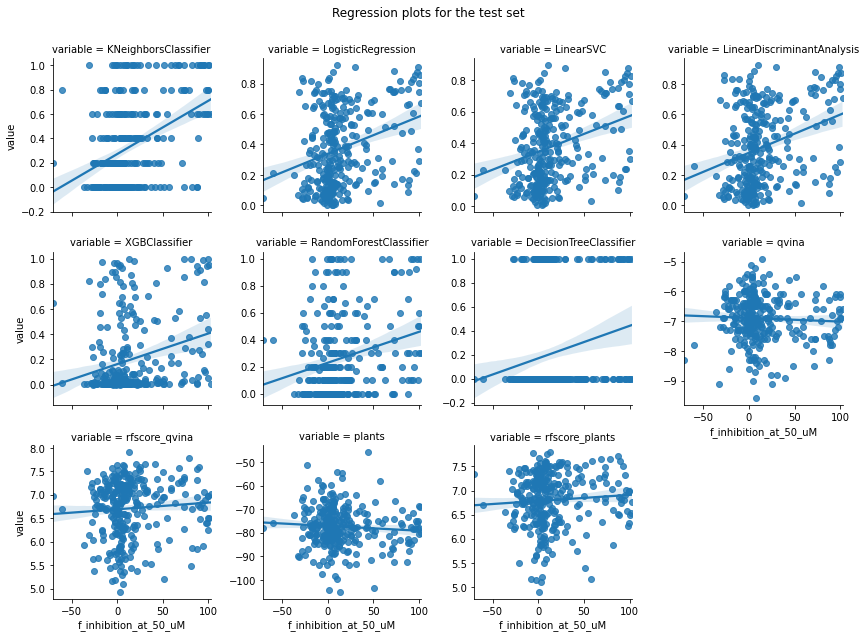

In [19]:
g = sns.FacetGrid(data=df_tidy, col='variable', col_wrap=4, sharey=False)
g.map(sns.regplot, 'f_inhibition_at_50_uM', 'value')

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Regression plots for the test set')

<a id='supplementary'></a>
## Supplementary data
<a id='correlations'></a>
### Correlations

In [20]:
# Pearson correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='pearson')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.778507
f_inhibition_at_50_uM,0.778507,1.000000
DecisionTreeClassifier,0.293472,0.220456
KNeighborsClassifier,0.354331,0.427977
LinearDiscriminantAnalysis,0.352388,0.328657
LinearSVC,0.344706,0.320076
LogisticRegression,0.349123,0.321035
RandomForestClassifier,0.323901,0.235310
XGBClassifier,0.311186,0.276670


In [21]:
# Spearman correlations with inhibitions
df_tidy.pivot_table(index=['CID','r_inhibition_at_50_uM','f_inhibition_at_50_uM'], 
                    columns='variable',values='value').reset_index().corr(method='spearman')[['r_inhibition_at_50_uM','f_inhibition_at_50_uM']]

variable,r_inhibition_at_50_uM,f_inhibition_at_50_uM
variable,,
r_inhibition_at_50_uM,1.000000,0.635991
f_inhibition_at_50_uM,0.635991,1.000000
DecisionTreeClassifier,0.225250,0.153987
KNeighborsClassifier,0.233380,0.348295
LinearDiscriminantAnalysis,0.267904,0.283379
LinearSVC,0.262436,0.277881
LogisticRegression,0.266121,0.279528
RandomForestClassifier,0.253817,0.186648
XGBClassifier,0.279651,0.229922


<a id='comparing'></a>
### Comparing models and labels

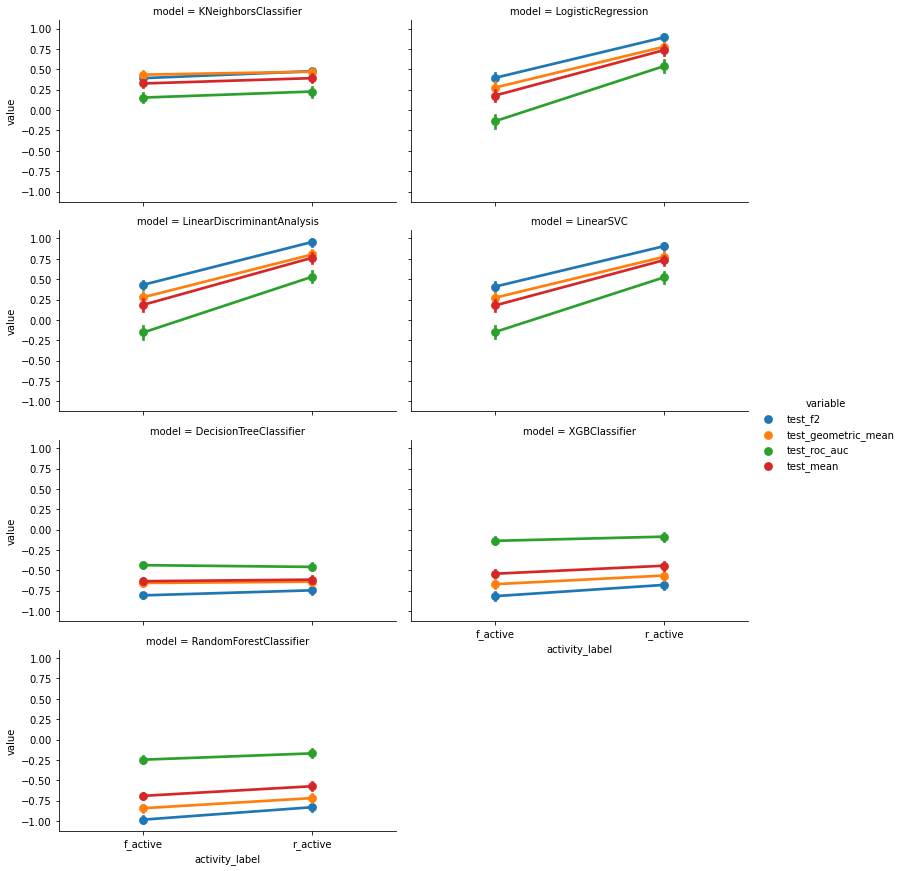

In [22]:
melt = pd.melt(scores_data, id_vars=['activity_label','model',*trainset], value_vars=[*test_metrics,'test_mean'])
sns.catplot(kind='point', data=melt, x='activity_label', y='value', hue='variable', col='model', col_wrap=2, height=3, aspect=1.75)

In [23]:
df = scores_data.groupby(['model','activity_label']).describe()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

test_accuracy                      \
                                                  count      mean       std   
model                      activity_label                                     
DecisionTreeClassifier     f_active               884.0  0.511918  0.410984   
                           r_active               884.0  0.437878  0.406794   
KNeighborsClassifier       f_active               884.0 -0.364566  0.507026   
                           r_active               884.0 -0.235758  0.572363   
LinearDiscriminantAnalysis f_active               884.0 -1.017037  0.761944   
                           r_active               884.0 -0.553569  0.790919   
LinearSVC                  f_active               884.0 -0.956570  0.795659   
                           r_active               884.0 -0.466708  0.837694   
LogisticRegression         f_active               884.0 -0.903030  0.811479   
                           r_active               884.0 -0.404141  0.865853   
RandomForestClassifier     f_active               884.0  1.038024  0.506370   
                           r_active               884.0  0.992506  0.508055   
XGBClassifier              f_active               884.0  0.994441  0.561796   
                           r_active               884.0  0.926610  0.551055   

                                                                         \
                                                min       25%       50%   
model                      activity_label                                 
DecisionTreeClassifier     f_active       -1.527890  0.342653  0.578949   
                           r_active       -1.486945  0.262125  0.504034   
KNeighborsClassifier       f_active       -1.825989 -0.709651 -0.269852   
                           r_active       -1.722500 -0.616545 -0.171061   
LinearDiscriminantAnalysis f_active       -3.096360 -1.642752 -0.897539   
                           r_active       -2.842038 -1.095381 -0.314532   
LinearSVC                  f_active       -3.072903 -1.638042 -0.824938   
                           r_active       -2.821674 -1.085239 -0.188416   
LogisticRegression         f_active       -3.026008 -1.630090 -0.703779   
                           r_active       -2.816928 -1.047416 -0.113855   
RandomForestClassifier     f_active       -1.659924  0.814272  1.111730   
                           r_active       -1.544003  0.764026  1.090884   
XGBClassifier              f_active       -1.581370  0.704606  1.162503   
                           r_active       -1.482290  0.664980  1.053710   

                                                              test_precision  \
                                                75%       max          count   
model                      activity_label                                      
DecisionTreeClassifier     f_active        0.779984  1.315260          884.0   
                           r_active        0.716812  1.309053          884.0   
KNeighborsClassifier       f_active       -0.009277  0.973982          884.0   
                           r_active        0.209749  0.933655          884.0   
LinearDiscriminantAnalysis f_active       -0.439240  0.260317          884.0   
                           r_active        0.042266  0.678928          884.0   
LinearSVC                  f_active       -0.387061  0.346302          884.0   
                           r_active        0.178003  0.754242          884.0   
LogisticRegression         f_active       -0.379468  0.369225          884.0   
                           r_active        0.274757  0.753650          884.0   
RandomForestClassifier     f_active        1.372982  1.844095          884.0   
                           r_active        1.328051  1.900774          884.0   
XGBClassifier              f_active        1.401576  1.854302          884.0   
                           r_active        1.310857  1.762940          884.0   

                                                             

<a id='docking'></a>
### Docking scores and performance increment

Text(0.5, 1.05, 'test_roc_auc')

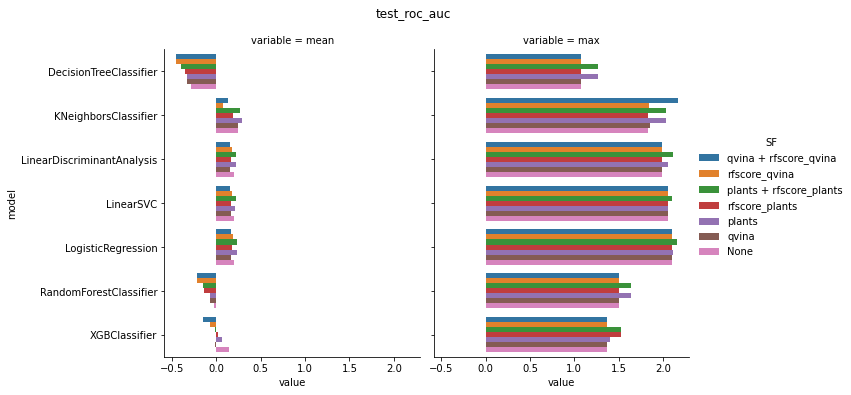

In [24]:
combinations = [('qvina', 'rfscore_qvina'),
                ('plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants'),
                ('qvina', 'rfscore_qvina', 'rfscore_plants'),
                ('qvina', 'plants', 'rfscore_plants'),
                ('rfscore_qvina', 'plants', 'rfscore_plants'),
                ('qvina', 'rfscore_qvina', 'plants', 'rfscore_plants')]

df = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
df['SF'] = 'None'

tmp = scores_data.query('rfscore_qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('plants == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'qvina + rfscore_qvina'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and rfscore_plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0 and plants == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'rfscore_plants'
df = df.append(tmp)

tmp = scores_data.query('qvina == 0 and rfscore_qvina == 0').groupby('model').describe()['test_roc_auc'][['mean','max']]
tmp['SF'] = 'plants + rfscore_plants'
df = df.append(tmp)

del tmp
df.reset_index(inplace=True)
df.sort_values(['model','mean','max'], inplace=True)

compare = pd.melt(df, id_vars=['model','SF'], value_vars=['mean','max'])
sns.catplot(kind='bar', data=compare, y='model', x='value', col='variable', hue='SF')
plt.suptitle('test_roc_auc', y=1.05)

The barplot above indicates the performance scores don't increase when docking scores are taken into account. In fact, all models' average scores, and most models' top scores, are higher when only the molecular descriptors are evaluated, although "qvina" and "qvina" + "rfscore_qvina" consistently have higher scores for all models.

<a id='top_descriptors'></a>
### Top descriptors

Text(0.5, 0.98, 'Most frequent descriptors in the top 1% scores')

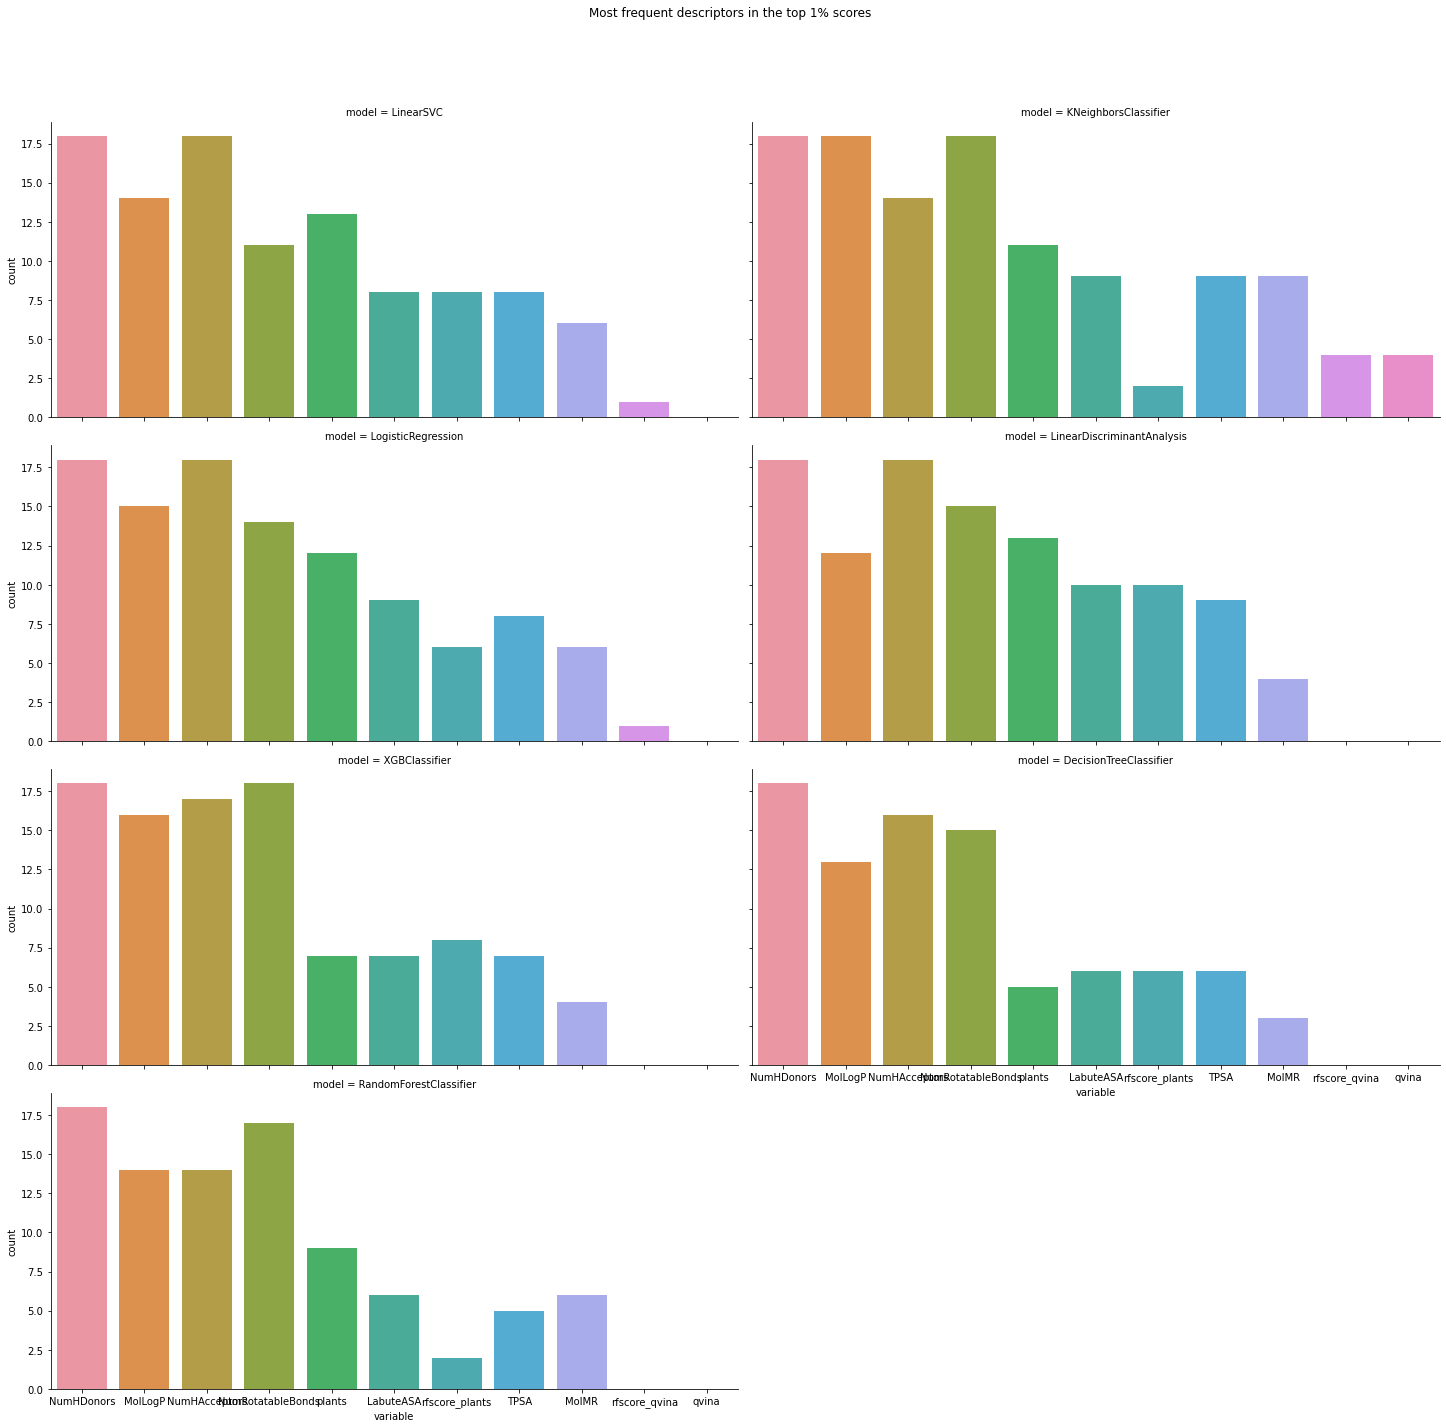

In [25]:
# How frequently does each descriptor appear in the top 1% scores for each model?
N = np.ceil(0.01 * len(scores_data.query('model == "LogisticRegression"')))
tmp = pd.melt(scores_data, id_vars=[*test_metrics,'activity_label','model','test_mean'], value_vars=trainset, value_name='count')
count = pd.DataFrame(tmp.groupby(['model','variable']).head(N).groupby(['model','variable'])['count'].value_counts())
del tmp

count.index.names = ['model','variable','value']
count.reset_index(level=[0,1,2], inplace=True)
count = count.query('value == 1').sort_values('count', ascending=False)
count.drop('value', axis=1, inplace=True)

g = sns.catplot(kind='bar', data=count, x='variable', y='count', col='model', col_wrap=2, aspect=2)

# Set title
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Most frequent descriptors in the top 1% scores')

The frequency count shows the most recurring descriptors in each model's top 1% results are: 

In [26]:
for key, value in best_subset.items():
    print(key, value)
    print()

KNeighborsClassifier ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'qvina', 'rfscore_qvina']

LogisticRegression ['MolMR', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']

LinearSVC ['MolMR', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']

LinearDiscriminantAnalysis ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP', 'rfscore_qvina']

XGBClassifier ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'LabuteASA', 'MolLogP', 'rfscore_plants']

RandomForestClassifier ['MolMR', 'NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'MolLogP']

DecisionTreeClassifier ['NumRotatableBonds', 'NumHAcceptors', 'NumHDonors', 'TPSA', 'MolLogP', 'rfscore_plants']



<a id='confusion_matrix'></a>
### Confusion matrix for the best model

In [39]:
# Confusion matrix

from sklearn.metrics import confusion_matrix, log_loss

model_name = top_scores.sort_values('test_mean', ascending=False).iloc[0]['model']
subset = best_subset[model_name]

y = new_data[activity_label]
X = new_data[subset]

scaler = StandardScaler()
pipe = make_pipeline(SMOTE(random_state=42), scaler, XGBClassifier(objective='reg:logistic', random_state=13))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for train_index, test_index in skf.split(X, y): 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] 
    break
    
pipe = pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

#     Predicted   inactive |  active
# Actual 
# inactive      |    TN    |    FP    | 
# active        |    FN    |    TP    | 

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
matrix = pd.DataFrame(conf_matrix)

print(model_name)
print(f'RMSE: {np.linalg.norm(y_proba - y_test) / np.sqrt(len(y_test)):.4f}')
print(f'log_loss: {log_loss(y_test, y_proba):.4f}')
matrix

KNeighborsClassifier
RMSE: 0.3718
log_loss: 0.5144


,0,1
0,0.883436,0.116564
1,0.615385,0.384615
